In [1]:
%pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from datasets import load_dataset
cifar100=load_dataset("cifar100")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
cifar100

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

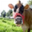

In [5]:
cifar100['train'][0]['img']
#fine_label->100 classes
#coarse_label->20 classes

In [6]:
labels=cifar100['train'].features['fine_label'].names
id2label={k:v for k,v in enumerate(labels)}
label2id={v:k for k,v in enumerate(labels)}

In [7]:
id2label[19]

'cattle'

In [8]:
len(id2label)

100

In [9]:
dataset=cifar100['train']
test_dataset=cifar100['test']

In [10]:
dataset=dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

In [11]:
train_dataset=dataset['train']
val_dataset=dataset['test']

In [12]:
train_dataset[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'fine_label': 94,
 'coarse_label': 6}

PROCESS DATA

In [13]:
from transformers import ConvNextFeatureExtractor
feature_extractor=ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [14]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [15]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

normalize=Normalize(mean=feature_extractor.image_mean,std=feature_extractor.image_std)

transform=Compose(
    [
        RandomResizedCrop(feature_extractor.size['shortest_edge']),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
    ]
)

def train_transforms(samples):
    samples["pixel_values"]=[transform(image.convert('RGB')) for image in samples['img']]
    return samples

In [16]:
train_dataset=train_dataset.with_transform(train_transforms)
val_dataset=val_dataset.with_transform(train_transforms)
test_dataset=test_dataset.with_transform(train_transforms)

In [17]:
train_dataset[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'fine_label': 94,
 'coarse_label': 6,
 'pixel_values': tensor([[[-0.5253, -0.5253, -0.5253,  ...,  2.2489,  2.2489,  2.2489],
          [-0.5253, -0.5253, -0.5253,  ...,  2.2489,  2.2489,  2.2489],
          [-0.5253, -0.5253, -0.5253,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.0116, -0.0116, -0.0116,  ...,  2.1119,  2.1119,  2.1119],
          [-0.0116, -0.0116, -0.0116,  ...,  2.1119,  2.1119,  2.1119],
          [-0.0116, -0.0116, -0.0116,  ...,  2.1119,  2.1119,  2.1119]],
 
         [[-1.3704, -1.3704, -1.3704,  ...,  2.4111,  2.4111,  2.4111],
          [-1.3704, -1.3704, -1.3704,  ...,  2.4111,  2.4111,  2.4111],
          [-1.3704, -1.3704, -1.3704,  ...,  2.4111,  2.4111,  2.4111],
          ...,
          [-0.4776, -0.4776, -0.4776,  ...,  2.3936,  2.3936,  2.3936],
          [-0.4776, -0.4776, -0.4776,  ...,  2.3936,  2.3936,  2.3936],
          [-0.4776, -0.4776, -0.4776,  ...,  2.3936

Model

In [18]:
from transformers import AutoModelForImageClassification
model=AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                      num_labels=len(id2label),
                                                      id2label=id2label,
                                                      label2id=label2id,
                                                      ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train

In [19]:
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [20]:
from torch.utils.data import DataLoader

def collate_fn(samples):
  pixel_values=torch.stack([sample['pixel_values'] for sample in samples])
  labels=torch.tensor([sample['fine_label'] for sample in samples])
  return {
      "pixel_values":pixel_values,
      "labels":labels
  }

train_loader=DataLoader(train_dataset,collate_fn=collate_fn,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,collate_fn=collate_fn,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,collate_fn=collate_fn,batch_size=32,shuffle=False)

In [21]:
batch=next(iter(train_loader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


In [22]:
optimizer=torch.optim.AdamW(model.parameters(),lr=5e-5)

In [ ]:
from tqdm import tqdm
import os

num_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

checkpoint_path = '/content/drive/MyDrive/Image Classification/checkpoint.pth'
# Check if a model checkpoint exists
if os.path.exists(checkpoint_path):
    # Load the model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    val_accuracy_best = checkpoint['val_accuracy_best']
    print("Model loaded successfully. Best validation accuracy:", val_accuracy_best)
else:
    print("No checkpoint found. Training from scratch.")
    val_accuracy_best = 0.0

for epoch in tqdm(range(num_epochs)):
    total = 0
    correct = 0
    model.train()
    for idx, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}')):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(pixel_values=batch['pixel_values'],
                        labels=batch['labels'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total += batch['labels'].shape[0]
        predicted = outputs.logits.argmax(-1)
        correct += (predicted == batch['labels']).sum().item()
        accuracy = correct / total

        if idx % 100 == 0:
            print(f"\nTraining Loss after {idx} steps: ", loss.item())
            print(f"\nTraining Accuracy after {idx} steps: ", accuracy)

    model.eval()
    val_total = 0
    val_correct = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(pixel_values=batch['pixel_values'],
                            labels=batch['labels'])
            val_total += batch['labels'].shape[0]
            predicted = outputs.logits.argmax(-1)
            val_correct += (predicted == batch['labels']).sum().item()

    val_accuracy = val_correct / val_total
    print(f"\nValidation Accuracy: ", val_accuracy)
    if val_accuracy >= val_accuracy_best:
        torch.save({'model_state_dict': model.state_dict(),
                    'val_accuracy_best': val_accuracy},
                    checkpoint_path)
        val_accuracy_best = val_accuracy
        print("Model checkpoint saved. Best validation accuracy improved.")

Model loaded successfully. Best validation accuracy: 0.8119


Epoch 1:   0%|          | 1/1250 [00:01<38:54,  1.87s/it]


Training Loss after 0 steps:  0.7343870401382446

Training Accuracy after 0 steps:  0.8125



Epoch 1:   8%|▊         | 101/1250 [00:49<09:28,  2.02it/s]


Training Loss after 100 steps:  0.9152741432189941

Training Accuracy after 100 steps:  0.8186881188118812



Epoch 1:  16%|█▌        | 201/1250 [01:42<09:34,  1.83it/s]


Training Loss after 200 steps:  0.7301440238952637

Training Accuracy after 200 steps:  0.8196517412935324



Epoch 1:  24%|██▍       | 301/1250 [02:34<08:28,  1.87it/s]


Training Loss after 300 steps:  0.5468865633010864

Training Accuracy after 300 steps:  0.8201827242524917



Epoch 1:  32%|███▏      | 401/1250 [03:27<07:30,  1.89it/s]


Training Loss after 400 steps:  0.4665524959564209

Training Accuracy after 400 steps:  0.8227088528678305



Epoch 1:  40%|████      | 501/1250 [04:19<06:44,  1.85it/s]


Training Loss after 500 steps:  0.8733574748039246

Training Accuracy after 500 steps:  0.8220434131736527



Epoch 1:  48%|████▊     | 601/1250 [05:12<05:45,  1.88it/s]


Training Loss after 600 steps:  0.8485617637634277

Training Accuracy after 600 steps:  0.8200915141430949



Epoch 1:  56%|█████▌    | 701/1250 [06:04<04:48,  1.90it/s]


Training Loss after 700 steps:  0.7075779438018799

Training Accuracy after 700 steps:  0.8173591298145506



Epoch 1:  64%|██████▍   | 801/1250 [06:57<03:52,  1.93it/s]


Training Loss after 800 steps:  1.4328148365020752

Training Accuracy after 800 steps:  0.8167134831460674



Epoch 1:  72%|███████▏  | 901/1250 [07:50<03:01,  1.92it/s]


Training Loss after 900 steps:  0.6382737159729004

Training Accuracy after 900 steps:  0.8168701442841287



Epoch 1:  80%|████████  | 1001/1250 [08:43<02:10,  1.91it/s]


Training Loss after 1000 steps:  0.514777421951294

Training Accuracy after 1000 steps:  0.8171203796203796



Epoch 1:  88%|████████▊ | 1101/1250 [09:35<01:17,  1.91it/s]


Training Loss after 1100 steps:  0.9060183167457581

Training Accuracy after 1100 steps:  0.8157073115349682



Epoch 1:  96%|█████████▌| 1201/1250 [10:28<00:25,  1.93it/s]


Training Loss after 1200 steps:  0.35107421875

Training Accuracy after 1200 steps:  0.8146336386344712



Epoch 1: 100%|██████████| 1250/1250 [10:54<00:00,  1.91it/s]

Validation: 100%|██████████| 313/313 [01:04<00:00,  4.83it/s]



Validation Accuracy:  0.8151


  2%|▏         | 1/50 [11:59<9:47:39, 719.58s/it]

Model checkpoint saved. Best validation accuracy improved.



Epoch 2:   0%|          | 1/1250 [00:00<10:52,  1.91it/s]


Training Loss after 0 steps:  0.6053846478462219

Training Accuracy after 0 steps:  0.875



Epoch 2:   8%|▊         | 101/1250 [00:53<10:00,  1.91it/s]


Training Loss after 100 steps:  0.4588949680328369

Training Accuracy after 100 steps:  0.8326113861386139



Epoch 2:  16%|█▌        | 201/1250 [01:45<09:07,  1.91it/s]


Training Loss after 200 steps:  0.48361003398895264

Training Accuracy after 200 steps:  0.8404850746268657



Epoch 2:  24%|██▍       | 301/1250 [02:38<08:22,  1.89it/s]


Training Loss after 300 steps:  0.8153248429298401

Training Accuracy after 300 steps:  0.8350290697674418



Epoch 2:  32%|███▏      | 401/1250 [03:32<07:39,  1.85it/s]


Training Loss after 400 steps:  0.3147697150707245

Training Accuracy after 400 steps:  0.8329956359102244



Epoch 2:  40%|████      | 501/1250 [04:25<06:48,  1.83it/s]


Training Loss after 500 steps:  1.3356666564941406

Training Accuracy after 500 steps:  0.8304640718562875



Epoch 2:  48%|████▊     | 601/1250 [05:18<05:49,  1.86it/s]


Training Loss after 600 steps:  1.2710210084915161

Training Accuracy after 600 steps:  0.8285149750415973



Epoch 2:  56%|█████▌    | 701/1250 [06:11<04:57,  1.84it/s]


Training Loss after 700 steps:  0.6557445526123047

Training Accuracy after 700 steps:  0.8270328102710414



Epoch 2:  64%|██████▍   | 801/1250 [07:03<04:03,  1.85it/s]


Training Loss after 800 steps:  0.7971572279930115

Training Accuracy after 800 steps:  0.8275983146067416



Epoch 2:  72%|███████▏  | 901/1250 [07:57<03:07,  1.86it/s]


Training Loss after 900 steps:  0.7416365146636963

Training Accuracy after 900 steps:  0.8278301886792453



Epoch 2:  80%|████████  | 1001/1250 [08:49<02:12,  1.88it/s]


Training Loss after 1000 steps:  0.9343875646591187

Training Accuracy after 1000 steps:  0.8275474525474525



Epoch 2:  88%|████████▊ | 1101/1250 [09:42<01:20,  1.86it/s]


Training Loss after 1100 steps:  0.9993577599525452

Training Accuracy after 1100 steps:  0.8277702089009991



Epoch 2:  96%|█████████▌| 1201/1250 [10:35<00:25,  1.89it/s]


Training Loss after 1200 steps:  0.5260249972343445

Training Accuracy after 1200 steps:  0.8285022897585346



Epoch 2: 100%|██████████| 1250/1250 [11:01<00:00,  1.89it/s]

  4%|▍         | 2/50 [24:07<9:39:36, 724.52s/it]


Validation Accuracy:  0.8135



Epoch 3:   0%|          | 1/1250 [00:00<10:42,  1.94it/s]


Training Loss after 0 steps:  0.45985180139541626

Training Accuracy after 0 steps:  0.875



Epoch 3:   8%|▊         | 101/1250 [00:53<10:06,  1.90it/s]


Training Loss after 100 steps:  0.7434234619140625

Training Accuracy after 100 steps:  0.8313737623762376



Epoch 3:  16%|█▌        | 201/1250 [01:46<09:08,  1.91it/s]


Training Loss after 200 steps:  0.8825682997703552

Training Accuracy after 200 steps:  0.8336442786069652



Epoch 3:  24%|██▍       | 301/1250 [02:39<08:16,  1.91it/s]


Training Loss after 300 steps:  0.6194187998771667

Training Accuracy after 300 steps:  0.8321220930232558



Epoch 3:  32%|███▏      | 401/1250 [03:32<07:41,  1.84it/s]


Training Loss after 400 steps:  0.6851993203163147

Training Accuracy after 400 steps:  0.8350997506234414



Epoch 3:  40%|████      | 501/1250 [04:25<06:38,  1.88it/s]


Training Loss after 500 steps:  0.3426617681980133

Training Accuracy after 500 steps:  0.8332709580838323



Epoch 3:  48%|████▊     | 601/1250 [05:18<05:38,  1.92it/s]


Training Loss after 600 steps:  0.689588189125061

Training Accuracy after 600 steps:  0.834130615640599



Epoch 3:  56%|█████▌    | 701/1250 [06:11<04:47,  1.91it/s]


Training Loss after 700 steps:  0.30978158116340637

Training Accuracy after 700 steps:  0.8336751069900142



Epoch 3:  64%|██████▍   | 801/1250 [07:04<03:55,  1.91it/s]


Training Loss after 800 steps:  0.5104262828826904

Training Accuracy after 800 steps:  0.8323579900124844



Epoch 3:  72%|███████▏  | 901/1250 [07:57<03:03,  1.90it/s]


Training Loss after 900 steps:  0.5996526479721069

Training Accuracy after 900 steps:  0.8329980577136515



Epoch 3:  80%|████████  | 1001/1250 [08:51<02:11,  1.89it/s]


Training Loss after 1000 steps:  0.4981650114059448

Training Accuracy after 1000 steps:  0.8321366133866134



Epoch 3:  88%|████████▊ | 1101/1250 [09:44<01:18,  1.90it/s]


Training Loss after 1100 steps:  0.9492611885070801

Training Accuracy after 1100 steps:  0.8310910535876476



Epoch 3:  96%|█████████▌| 1201/1250 [10:37<00:25,  1.90it/s]


Training Loss after 1200 steps:  0.5296072363853455

Training Accuracy after 1200 steps:  0.8319109075770191



Epoch 3: 100%|██████████| 1250/1250 [11:03<00:00,  1.88it/s]

  6%|▌         | 3/50 [36:16<9:29:15, 726.72s/it]


Validation Accuracy:  0.8092



Epoch 4:   0%|          | 1/1250 [00:00<10:57,  1.90it/s]


Training Loss after 0 steps:  0.6645106077194214

Training Accuracy after 0 steps:  0.78125



Epoch 4:   8%|▊         | 101/1250 [00:53<10:16,  1.86it/s]


Training Loss after 100 steps:  0.5505250096321106

Training Accuracy after 100 steps:  0.8406559405940595



Epoch 4:  16%|█▌        | 201/1250 [01:46<09:33,  1.83it/s]


Training Loss after 200 steps:  0.48006516695022583

Training Accuracy after 200 steps:  0.8415733830845771



Epoch 4:  24%|██▍       | 301/1250 [02:40<08:30,  1.86it/s]


Training Loss after 300 steps:  0.65879887342453

Training Accuracy after 300 steps:  0.8411544850498339



Epoch 4:  32%|███▏      | 401/1250 [03:33<07:32,  1.88it/s]


Training Loss after 400 steps:  0.20368511974811554

Training Accuracy after 400 steps:  0.8429706982543641



Epoch 4:  40%|████      | 501/1250 [04:26<06:36,  1.89it/s]


Training Loss after 500 steps:  0.5043887495994568

Training Accuracy after 500 steps:  0.842564870259481



Epoch 4:  48%|████▊     | 601/1250 [05:20<05:45,  1.88it/s]


Training Loss after 600 steps:  1.0140832662582397

Training Accuracy after 600 steps:  0.843801996672213



Epoch 4:  56%|█████▌    | 701/1250 [06:13<04:49,  1.90it/s]


Training Loss after 700 steps:  0.3193229138851166

Training Accuracy after 700 steps:  0.84214514978602



Epoch 4:  64%|██████▍   | 801/1250 [07:06<03:58,  1.88it/s]


Training Loss after 800 steps:  0.623705267906189

Training Accuracy after 800 steps:  0.8431257802746567



Epoch 4:  72%|███████▏  | 901/1250 [07:59<03:05,  1.88it/s]


Training Loss after 900 steps:  0.4145658612251282

Training Accuracy after 900 steps:  0.8423279689234184



Epoch 4:  80%|████████  | 1001/1250 [08:53<02:11,  1.90it/s]


Training Loss after 1000 steps:  0.5295620560646057

Training Accuracy after 1000 steps:  0.8433129370629371



Epoch 4:  88%|████████▊ | 1101/1250 [09:47<01:19,  1.88it/s]


Training Loss after 1100 steps:  0.9964820742607117

Training Accuracy after 1100 steps:  0.8438067665758402



Epoch 4:  96%|█████████▌| 1201/1250 [10:40<00:25,  1.89it/s]


Training Loss after 1200 steps:  0.6228911280632019

Training Accuracy after 1200 steps:  0.8435938800999168



Epoch 4: 100%|██████████| 1250/1250 [11:06<00:00,  1.88it/s]

  8%|▊         | 4/50 [48:29<9:19:04, 729.24s/it]


Validation Accuracy:  0.8091



Epoch 5:   0%|          | 1/1250 [00:00<10:55,  1.91it/s]


Training Loss after 0 steps:  0.6191103458404541

Training Accuracy after 0 steps:  0.8125



Epoch 5:   8%|▊         | 101/1250 [00:54<10:10,  1.88it/s]


Training Loss after 100 steps:  0.6308394074440002

Training Accuracy after 100 steps:  0.8483910891089109



Epoch 5:  16%|█▌        | 201/1250 [01:47<09:17,  1.88it/s]


Training Loss after 200 steps:  0.39685654640197754

Training Accuracy after 200 steps:  0.8564987562189055



Epoch 5:  24%|██▍       | 301/1250 [02:40<08:23,  1.89it/s]


Training Loss after 300 steps:  0.6181188225746155

Training Accuracy after 300 steps:  0.8525747508305648



Epoch 5:  32%|███▏      | 401/1250 [03:34<07:33,  1.87it/s]


Training Loss after 400 steps:  0.6296444535255432

Training Accuracy after 400 steps:  0.8520885286783042



Epoch 5:  40%|████      | 501/1250 [04:27<06:39,  1.87it/s]


Training Loss after 500 steps:  0.183024600148201

Training Accuracy after 500 steps:  0.8515469061876247



Epoch 5:  48%|████▊     | 601/1250 [05:21<05:45,  1.88it/s]


Training Loss after 600 steps:  0.7320180535316467

Training Accuracy after 600 steps:  0.8508735440931781



Epoch 5:  56%|█████▌    | 701/1250 [06:14<04:54,  1.87it/s]


Training Loss after 700 steps:  0.639054000377655

Training Accuracy after 700 steps:  0.8502139800285307



Epoch 5:  64%|██████▍   | 801/1250 [07:08<04:00,  1.87it/s]


Training Loss after 800 steps:  0.636185348033905

Training Accuracy after 800 steps:  0.8487827715355806



Epoch 5:  72%|███████▏  | 901/1250 [08:01<03:03,  1.90it/s]


Training Loss after 900 steps:  0.6561727523803711

Training Accuracy after 900 steps:  0.8490219200887902



Epoch 5:  80%|████████  | 1001/1250 [08:55<02:13,  1.87it/s]


Training Loss after 1000 steps:  0.41093480587005615

Training Accuracy after 1000 steps:  0.8493069430569431



Epoch 5:  88%|████████▊ | 1101/1250 [09:48<01:20,  1.86it/s]


Training Loss after 1100 steps:  0.48524343967437744

Training Accuracy after 1100 steps:  0.8491144414168937



Epoch 5:  96%|█████████▌| 1201/1250 [10:42<00:26,  1.88it/s]


Training Loss after 1200 steps:  0.4881943166255951

Training Accuracy after 1200 steps:  0.8481733971690258



Epoch 5: 100%|██████████| 1250/1250 [11:08<00:00,  1.87it/s]

 10%|█         | 5/50 [1:00:46<9:08:50, 731.78s/it]


Validation Accuracy:  0.8046



Epoch 6:   0%|          | 1/1250 [00:00<11:03,  1.88it/s]


Training Loss after 0 steps:  0.45813098549842834

Training Accuracy after 0 steps:  0.84375



Epoch 6:   8%|▊         | 101/1250 [00:54<10:13,  1.87it/s]


Training Loss after 100 steps:  0.6357077360153198

Training Accuracy after 100 steps:  0.8558168316831684



Epoch 6:  16%|█▌        | 201/1250 [01:48<09:39,  1.81it/s]


Training Loss after 200 steps:  0.40217435359954834

Training Accuracy after 200 steps:  0.8583644278606966



Epoch 6:  24%|██▍       | 301/1250 [02:41<08:33,  1.85it/s]


Training Loss after 300 steps:  0.5188122987747192

Training Accuracy after 300 steps:  0.8605689368770764



Epoch 6:  32%|███▏      | 401/1250 [03:35<07:29,  1.89it/s]


Training Loss after 400 steps:  0.4746350646018982

Training Accuracy after 400 steps:  0.8596477556109726



Epoch 6:  40%|████      | 501/1250 [04:29<06:40,  1.87it/s]


Training Loss after 500 steps:  0.288870632648468

Training Accuracy after 500 steps:  0.8600299401197605



Epoch 6:  48%|████▊     | 601/1250 [05:22<05:46,  1.88it/s]


Training Loss after 600 steps:  0.6155610084533691

Training Accuracy after 600 steps:  0.8577891014975042



Epoch 6:  56%|█████▌    | 701/1250 [06:16<04:53,  1.87it/s]


Training Loss after 700 steps:  0.24737760424613953

Training Accuracy after 700 steps:  0.8568562767475035



Epoch 6:  64%|██████▍   | 801/1250 [07:10<04:00,  1.87it/s]


Training Loss after 800 steps:  0.36687713861465454

Training Accuracy after 800 steps:  0.8563514357053683



Epoch 6:  72%|███████▏  | 901/1250 [08:03<03:07,  1.86it/s]


Training Loss after 900 steps:  0.3726005256175995

Training Accuracy after 900 steps:  0.8563401775804661



Epoch 6:  80%|████████  | 1001/1250 [08:57<02:12,  1.88it/s]


Training Loss after 1000 steps:  0.3575019836425781

Training Accuracy after 1000 steps:  0.8547702297702298



Epoch 6:  88%|████████▊ | 1101/1250 [09:51<01:19,  1.86it/s]


Training Loss after 1100 steps:  0.48276329040527344

Training Accuracy after 1100 steps:  0.8544221162579473



Epoch 6:  96%|█████████▌| 1201/1250 [10:45<00:26,  1.88it/s]


Training Loss after 1200 steps:  0.7466171383857727

Training Accuracy after 1200 steps:  0.8531692339716903



Epoch 6: 100%|██████████| 1250/1250 [11:11<00:00,  1.86it/s]

 12%|█▏        | 6/50 [1:13:06<8:58:46, 734.69s/it]


Validation Accuracy:  0.8117



Epoch 7:   0%|          | 1/1250 [00:00<10:59,  1.89it/s]


Training Loss after 0 steps:  0.6032297611236572

Training Accuracy after 0 steps:  0.8125



Epoch 7:   8%|▊         | 101/1250 [00:54<10:12,  1.88it/s]


Training Loss after 100 steps:  0.3333224058151245

Training Accuracy after 100 steps:  0.8586014851485149



Epoch 7:  16%|█▌        | 201/1250 [01:48<09:18,  1.88it/s]


Training Loss after 200 steps:  0.34107476472854614

Training Accuracy after 200 steps:  0.8586753731343284



Epoch 7:  24%|██▍       | 301/1250 [02:41<08:26,  1.87it/s]


Training Loss after 300 steps:  0.18899334967136383

Training Accuracy after 300 steps:  0.8591154485049833



Epoch 7:  32%|███▏      | 401/1250 [03:35<07:34,  1.87it/s]


Training Loss after 400 steps:  0.42679235339164734

Training Accuracy after 400 steps:  0.8589463840399002



Epoch 7:  40%|████      | 501/1250 [04:29<06:37,  1.88it/s]


Training Loss after 500 steps:  0.8347349166870117

Training Accuracy after 500 steps:  0.8571606786427146



Epoch 7:  48%|████▊     | 601/1250 [05:23<05:46,  1.87it/s]


Training Loss after 600 steps:  0.3737226128578186

Training Accuracy after 600 steps:  0.858101081530782



Epoch 7:  56%|█████▌    | 701/1250 [06:17<04:53,  1.87it/s]


Training Loss after 700 steps:  0.39964941143989563

Training Accuracy after 700 steps:  0.8597093437945792



Epoch 7:  64%|██████▍   | 801/1250 [07:10<03:58,  1.89it/s]


Training Loss after 800 steps:  0.4426558315753937

Training Accuracy after 800 steps:  0.8601747815230961



Epoch 7:  72%|███████▏  | 901/1250 [08:04<03:05,  1.88it/s]


Training Loss after 900 steps:  0.8833479285240173

Training Accuracy after 900 steps:  0.8608837402885683



Epoch 7:  80%|████████  | 1001/1250 [08:58<02:13,  1.86it/s]


Training Loss after 1000 steps:  0.3844287395477295

Training Accuracy after 1000 steps:  0.8597964535464535



Epoch 7:  88%|████████▊ | 1101/1250 [09:52<01:19,  1.87it/s]


Training Loss after 1100 steps:  1.083168625831604

Training Accuracy after 1100 steps:  0.8591905086285195



Epoch 7:  96%|█████████▌| 1201/1250 [10:46<00:26,  1.87it/s]


Training Loss after 1200 steps:  0.37916862964630127

Training Accuracy after 1200 steps:  0.8591538301415487



Epoch 7: 100%|██████████| 1250/1250 [11:12<00:00,  1.86it/s]

 14%|█▍        | 7/50 [1:25:27<8:48:05, 736.87s/it]


Validation Accuracy:  0.8047



Epoch 8:   0%|          | 1/1250 [00:00<10:59,  1.89it/s]


Training Loss after 0 steps:  0.4189474284648895

Training Accuracy after 0 steps:  0.90625



Epoch 8:   8%|▊         | 101/1250 [00:54<10:13,  1.87it/s]


Training Loss after 100 steps:  0.4448535740375519

Training Accuracy after 100 steps:  0.8678836633663366



Epoch 8:  16%|█▌        | 201/1250 [01:48<09:23,  1.86it/s]


Training Loss after 200 steps:  0.829529881477356

Training Accuracy after 200 steps:  0.8664490049751243



Epoch 8:  24%|██▍       | 301/1250 [02:42<08:33,  1.85it/s]


Training Loss after 300 steps:  0.5194756388664246

Training Accuracy after 300 steps:  0.8673172757475083



Epoch 8:  32%|███▏      | 401/1250 [03:36<07:31,  1.88it/s]


Training Loss after 400 steps:  0.4744655191898346

Training Accuracy after 400 steps:  0.8697007481296758



Epoch 8:  40%|████      | 501/1250 [04:29<06:50,  1.82it/s]


Training Loss after 500 steps:  0.29811859130859375

Training Accuracy after 500 steps:  0.8684505988023952



Epoch 8:  48%|████▊     | 601/1250 [05:24<06:02,  1.79it/s]


Training Loss after 600 steps:  0.3401520252227783

Training Accuracy after 600 steps:  0.8682924292845258



Epoch 8:  56%|█████▌    | 701/1250 [06:18<05:00,  1.83it/s]


Training Loss after 700 steps:  0.5050159692764282

Training Accuracy after 700 steps:  0.8674661198288159



Epoch 8:  64%|██████▍   | 801/1250 [07:12<04:04,  1.84it/s]


Training Loss after 800 steps:  0.5770363807678223

Training Accuracy after 800 steps:  0.8654416354556804



Epoch 8:  72%|███████▏  | 901/1250 [08:06<03:15,  1.78it/s]


Training Loss after 900 steps:  0.6916879415512085

Training Accuracy after 900 steps:  0.8662250277469479



Epoch 8:  80%|████████  | 1001/1250 [09:00<02:17,  1.81it/s]


Training Loss after 1000 steps:  0.33389803767204285

Training Accuracy after 1000 steps:  0.8671953046953047



Epoch 8:  88%|████████▊ | 1101/1250 [09:55<01:21,  1.83it/s]


Training Loss after 1100 steps:  0.1873081922531128

Training Accuracy after 1100 steps:  0.8674216621253406



Epoch 8:  96%|█████████▌| 1201/1250 [10:49<00:26,  1.84it/s]


Training Loss after 1200 steps:  0.4421473741531372

Training Accuracy after 1200 steps:  0.8674281848459617



Epoch 8: 100%|██████████| 1250/1250 [11:16<00:00,  1.85it/s]

 16%|█▌        | 8/50 [1:37:54<8:38:02, 740.06s/it]


Validation Accuracy:  0.807



Epoch 9:   0%|          | 1/1250 [00:00<11:18,  1.84it/s]


Training Loss after 0 steps:  0.4147171378135681

Training Accuracy after 0 steps:  0.90625



Epoch 9:   8%|▊         | 101/1250 [00:54<10:40,  1.79it/s]


Training Loss after 100 steps:  0.7190873026847839

Training Accuracy after 100 steps:  0.8722153465346535



Epoch 9:  16%|█▌        | 201/1250 [01:48<09:36,  1.82it/s]


Training Loss after 200 steps:  1.1291803121566772

Training Accuracy after 200 steps:  0.8704912935323383



Epoch 9:  24%|██▍       | 301/1250 [02:43<08:39,  1.83it/s]


Training Loss after 300 steps:  0.638176679611206

Training Accuracy after 300 steps:  0.8719892026578073



Epoch 9:  32%|███▏      | 401/1250 [03:37<07:38,  1.85it/s]


Training Loss after 400 steps:  0.72712641954422

Training Accuracy after 400 steps:  0.8729738154613467



Epoch 9:  40%|████      | 501/1250 [04:32<06:53,  1.81it/s]


Training Loss after 500 steps:  0.7487100958824158

Training Accuracy after 500 steps:  0.8725049900199601



Epoch 9:  48%|████▊     | 601/1250 [05:26<05:55,  1.83it/s]


Training Loss after 600 steps:  0.7952436208724976

Training Accuracy after 600 steps:  0.8712042429284526



Epoch 9:  56%|█████▌    | 701/1250 [06:20<05:02,  1.81it/s]


Training Loss after 700 steps:  0.6372718811035156

Training Accuracy after 700 steps:  0.8708541369472182



Epoch 9:  64%|██████▍   | 801/1250 [07:14<04:09,  1.80it/s]


Training Loss after 800 steps:  0.41017553210258484

Training Accuracy after 800 steps:  0.8713327091136079



Epoch 9:  72%|███████▏  | 901/1250 [08:09<03:13,  1.80it/s]


Training Loss after 900 steps:  0.4954473078250885

Training Accuracy after 900 steps:  0.8717397336293008



Epoch 9:  80%|████████  | 1001/1250 [09:03<02:18,  1.80it/s]


Training Loss after 1000 steps:  0.3003797233104706

Training Accuracy after 1000 steps:  0.8723151848151848



Epoch 9:  88%|████████▊ | 1101/1250 [09:57<01:22,  1.80it/s]


Training Loss after 1100 steps:  0.5281991958618164

Training Accuracy after 1100 steps:  0.8708276566757494



Epoch 9:  96%|█████████▌| 1201/1250 [10:51<00:27,  1.81it/s]


Training Loss after 1200 steps:  0.6616801023483276

Training Accuracy after 1200 steps:  0.8697960033305578



Epoch 9: 100%|██████████| 1250/1250 [11:18<00:00,  1.84it/s]

 18%|█▊        | 9/50 [1:50:24<8:27:49, 743.16s/it]


Validation Accuracy:  0.8048



Epoch 10:   0%|          | 1/1250 [00:00<11:23,  1.83it/s]


Training Loss after 0 steps:  0.1687438040971756

Training Accuracy after 0 steps:  0.96875



Epoch 10:   8%|▊         | 101/1250 [00:54<10:17,  1.86it/s]


Training Loss after 100 steps:  0.2742907702922821

Training Accuracy after 100 steps:  0.885519801980198



Epoch 10:  16%|█▌        | 201/1250 [01:49<09:37,  1.82it/s]


Training Loss after 200 steps:  0.3009144365787506

Training Accuracy after 200 steps:  0.8799751243781094



Epoch 10:  24%|██▍       | 301/1250 [02:43<08:52,  1.78it/s]


Training Loss after 300 steps:  0.5766681432723999

Training Accuracy after 300 steps:  0.8776993355481728



Epoch 10:  32%|███▏      | 401/1250 [03:37<07:48,  1.81it/s]


Training Loss after 400 steps:  0.08163537085056305

Training Accuracy after 400 steps:  0.8757013715710723



Epoch 10:  40%|████      | 501/1250 [04:31<06:57,  1.79it/s]


Training Loss after 500 steps:  0.3717125356197357

Training Accuracy after 500 steps:  0.8739396207584831



Epoch 10:  48%|████▊     | 601/1250 [05:25<05:52,  1.84it/s]


Training Loss after 600 steps:  0.4110965430736542

Training Accuracy after 600 steps:  0.8740120632279534



Epoch 10:  56%|█████▌    | 701/1250 [06:20<05:02,  1.82it/s]


Training Loss after 700 steps:  0.17433330416679382

Training Accuracy after 700 steps:  0.8739300998573466



Epoch 10:  64%|██████▍   | 801/1250 [07:14<04:04,  1.84it/s]


Training Loss after 800 steps:  0.6830545663833618

Training Accuracy after 800 steps:  0.8720349563046192



Epoch 10:  72%|███████▏  | 901/1250 [08:08<03:11,  1.82it/s]


Training Loss after 900 steps:  0.3967670202255249

Training Accuracy after 900 steps:  0.8713235294117647



Epoch 10:  80%|████████  | 1001/1250 [09:02<02:18,  1.79it/s]


Training Loss after 1000 steps:  0.41366106271743774

Training Accuracy after 1000 steps:  0.8721903096903096



Epoch 10:  88%|████████▊ | 1101/1250 [09:57<01:20,  1.84it/s]


Training Loss after 1100 steps:  0.35087138414382935

Training Accuracy after 1100 steps:  0.872246821071753



Epoch 10:  96%|█████████▌| 1201/1250 [10:51<00:27,  1.81it/s]


Training Loss after 1200 steps:  0.4463469386100769

Training Accuracy after 1200 steps:  0.8715653621981682



Epoch 10: 100%|██████████| 1250/1250 [11:18<00:00,  1.84it/s]

 20%|██        | 10/50 [2:02:53<8:16:34, 744.87s/it]


Validation Accuracy:  0.8056



Epoch 11:   0%|          | 1/1250 [00:00<11:27,  1.82it/s]


Training Loss after 0 steps:  0.4169844388961792

Training Accuracy after 0 steps:  0.875



Epoch 11:   8%|▊         | 101/1250 [00:54<10:25,  1.84it/s]


Training Loss after 100 steps:  0.4743586480617523

Training Accuracy after 100 steps:  0.8737623762376238



Epoch 11:  16%|█▌        | 201/1250 [01:49<09:29,  1.84it/s]


Training Loss after 200 steps:  0.7580127716064453

Training Accuracy after 200 steps:  0.8756218905472637



Epoch 11:  24%|██▍       | 301/1250 [02:43<08:42,  1.82it/s]


Training Loss after 300 steps:  0.42108190059661865

Training Accuracy after 300 steps:  0.8800872093023255



Epoch 11:  32%|███▏      | 401/1250 [03:38<07:43,  1.83it/s]


Training Loss after 400 steps:  0.2796342968940735

Training Accuracy after 400 steps:  0.8802213216957606



Epoch 11:  40%|████      | 501/1250 [04:32<06:49,  1.83it/s]


Training Loss after 500 steps:  0.625404953956604

Training Accuracy after 500 steps:  0.8791167664670658



Epoch 11:  48%|████▊     | 601/1250 [05:26<06:03,  1.79it/s]


Training Loss after 600 steps:  0.27399876713752747

Training Accuracy after 600 steps:  0.8788477537437605



Epoch 11:  56%|█████▌    | 701/1250 [06:21<05:06,  1.79it/s]


Training Loss after 700 steps:  0.6658105254173279

Training Accuracy after 700 steps:  0.8787892296718973



Epoch 11:  64%|██████▍   | 801/1250 [07:15<04:12,  1.78it/s]


Training Loss after 800 steps:  0.3658456802368164

Training Accuracy after 800 steps:  0.8773798377028714



Epoch 11:  72%|███████▏  | 901/1250 [08:10<03:13,  1.81it/s]


Training Loss after 900 steps:  0.19467709958553314

Training Accuracy after 900 steps:  0.8786417869034406



Epoch 11:  80%|████████  | 1001/1250 [09:04<02:16,  1.83it/s]


Training Loss after 1000 steps:  0.647059977054596

Training Accuracy after 1000 steps:  0.8784028471528471



Epoch 11:  88%|████████▊ | 1101/1250 [09:59<01:22,  1.80it/s]


Training Loss after 1100 steps:  0.22754822671413422

Training Accuracy after 1100 steps:  0.878122161671208



Epoch 11:  96%|█████████▌| 1201/1250 [10:53<00:26,  1.84it/s]


Training Loss after 1200 steps:  1.098007321357727

Training Accuracy after 1200 steps:  0.8769254787676936



Epoch 11: 100%|██████████| 1250/1250 [11:20<00:00,  1.84it/s]

 22%|██▏       | 11/50 [2:15:24<8:05:17, 746.61s/it]


Validation Accuracy:  0.8051



Epoch 12:   0%|          | 1/1250 [00:00<10:51,  1.92it/s]


Training Loss after 0 steps:  0.3325181305408478

Training Accuracy after 0 steps:  0.9375



Epoch 12:   8%|▊         | 101/1250 [00:54<10:27,  1.83it/s]


Training Loss after 100 steps:  0.3791356682777405

Training Accuracy after 100 steps:  0.8910891089108911



Epoch 12:  16%|█▌        | 201/1250 [01:49<09:23,  1.86it/s]


Training Loss after 200 steps:  0.8202075362205505

Training Accuracy after 200 steps:  0.8858830845771144



Epoch 12:  24%|██▍       | 301/1250 [02:43<08:34,  1.84it/s]


Training Loss after 300 steps:  0.2949722707271576

Training Accuracy after 300 steps:  0.884032392026578



Epoch 12:  26%|██▌       | 319/1250 [02:53<08:22,  1.85it/s]

In [23]:
from transformers import AutoModelForImageClassification
from tqdm import tqdm
model=AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                      num_labels=len(id2label),
                                                      id2label=id2label,
                                                      label2id=label2id,
                                                      ignore_mismatched_sizes=True)

checkpoint_path = '/content/drive/MyDrive/Image Classification/checkpoint.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()
test_total = 0
test_correct = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=batch['pixel_values'],
                        labels=batch['labels'])
        test_total += batch['labels'].shape[0]
        predicted = outputs.logits.argmax(-1)
        test_correct += (predicted == batch['labels']).sum().item()

test_accuracy = test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy}")

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Testing: 100%|██████████| 313/313 [00:57<00:00,  5.42it/s]


Test Accuracy: 0.7459


Push to Hub and Inference

In [24]:
from huggingface_hub import notebook_login
notebook_login()

In [25]:
repo_name='karan99300/ConvNext-finetuned-CIFAR100'
model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/karan99300/ConvNext-finetuned-CIFAR100/commit/4794408786e7ee9be070cb79c66df40683dc525b', commit_message='Upload feature extractor', commit_description='', oid='4794408786e7ee9be070cb79c66df40683dc525b', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
from transformers import AutoFeatureExtractor,AutoModelForImageClassification

feature_extractor=AutoFeatureExtractor.from_pretrained('karan99300/ConvNext-finetuned-CIFAR100')
model=AutoModelForImageClassification.from_pretrained('karan99300/ConvNext-finetuned-CIFAR100')

preprocessor_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]

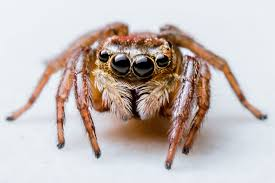

In [1]:
from PIL import Image
import requests

url='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS-4t_lq7lXTvPiZCZq96wQ9YgiAQnhn_-ia-Q8k31KKg&s'
image=Image.open(requests.get(url,stream=True).raw)
image

In [28]:
pixel_values=feature_extractor(image.convert('RGB'),return_tensors='pt').pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [29]:
with torch.no_grad():
  outputs=model(pixel_values)
  logits=outputs.logits

In [30]:
print(logits.shape)

torch.Size([1, 100])


In [31]:
predicted_class_idx=logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

spider
